In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
file_path = 'Desktop//train_5500.csv'
train = pd.read_csv(file_path)

In [3]:
#dti cannot be negative
train.loc[train["dti"]<0,"dti"]=0
#extract the year of employmwntlenght
train["employmentLength"]=train["employmentLength"].str.replace("< 1 year","0")
train["employmentLength"]=train["employmentLength"].str.replace("years","")
train["employmentLength"]=train["employmentLength"].str.replace("year","")
train["employmentLength"]=train["employmentLength"].str.replace("+","")
train["employmentLength"]=train["employmentLength"].str.replace(" ","")
train["employmentLength"]=train["employmentLength"].astype("float64")
# change the regioncode into object
train["regionCode"]=train["regionCode"].astype("object")
#trans the issue date in to year
train["issueDate"]=train["issueDate"].str.replace("-",".",1)
train["issueDate"]=train["issueDate"].str.replace("-01","")
train["issueDate"]=train["issueDate"].str.replace("20","")
train["issueDate"]=train["issueDate"].astype("float64")

In [4]:
#cover earliesCreditLine_month into year month
month=('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')
number=('01',"02",'03','04','05','06','07','08','09','10','11','12')
temp_month=dict(zip(month,number))

train[["earliesCreditLine_month","earliesCreditLine_year"]]=train["earliesCreditLine"].str.split("-",expand=True)
train["earliesCreditLine_month"]=train["earliesCreditLine_month"].map(temp_month)
train["earliesCreditLine"]=train["earliesCreditLine_year"]+"."+train["earliesCreditLine_month"]
train=train.drop(["earliesCreditLine_month","earliesCreditLine_year"],axis=1)
train["earliesCreditLine"]=train["earliesCreditLine"].astype("float64")
train["earliesCreditLine"]=train["earliesCreditLine"]-1944

In [5]:
# based on the grade and subgrade, ordinal encoding is used
subgrade_mapping = {f"{grade}{subgrade}": 7 - (i + subgrade / 10)
                    for i, grade in enumerate("ABCDEFG")
                    for subgrade in range(1, 6)}
train['subGrade'] = train['subGrade'].replace(subgrade_mapping)
train = train.drop('grade', axis=1)

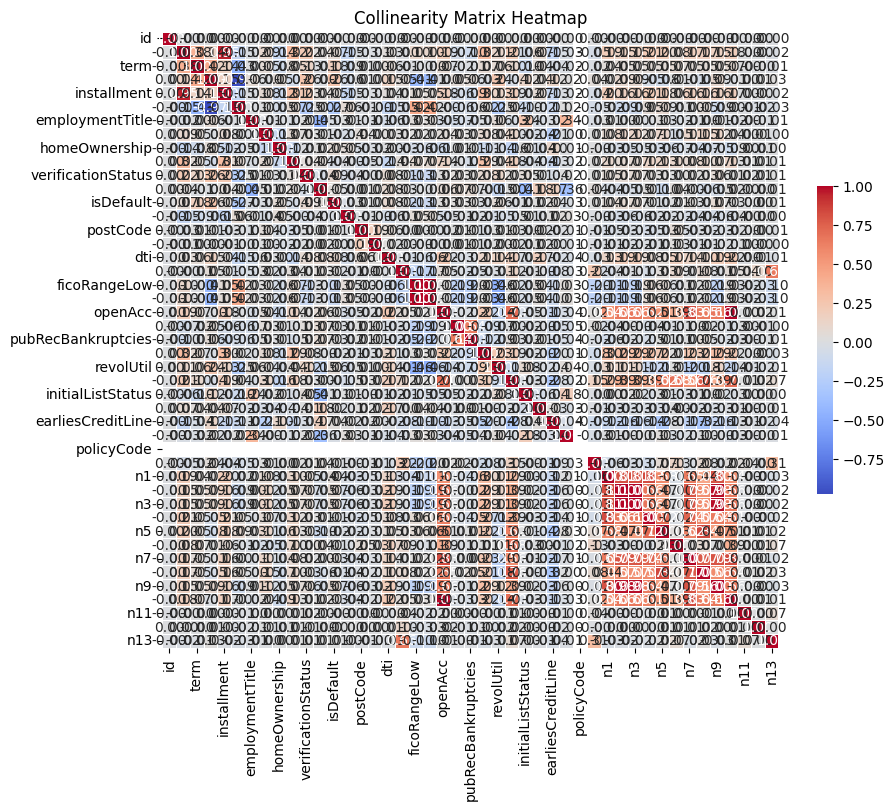

In [6]:
# plot the correlation
features = train.iloc[:,:-1]
collinearity_matrix = features.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(collinearity_matrix, annot=True, fmt=".2f", cmap='coolwarm',square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Collinearity Matrix Heatmap')
plt.show()

In [7]:
train.loc[:,"n0":"n14"]=train.loc[:,"n0":"n14"].fillna(0)
train.corr()["employmentLength"].sort_values()

earliesCreditLine    -0.214540
homeOwnership        -0.128706
applicationType      -0.040109
purpose              -0.037831
n6                   -0.034145
isDefault            -0.015822
initialListStatus    -0.015678
employmentTitle      -0.013586
title                -0.004879
interestRate         -0.003302
n13                   0.000055
id                    0.000474
regionCode            0.003762
n11                   0.003862
subGrade              0.004276
n12                   0.007545
issueDate             0.012494
n0                    0.017362
ficoRangeLow          0.018688
ficoRangeHigh         0.018689
delinquency_2years    0.021592
dti                   0.025623
pubRecBankruptcies    0.027587
verificationStatus    0.029196
pubRec                0.031045
n14                   0.035583
revolUtil             0.035735
postCode              0.039103
openAcc               0.042909
n10                   0.051922
term                  0.054812
annualIncome          0.067188
n4      

In [8]:
#select the features with more than 0.1 corelation to predict the employmentLength
employmentLengthPre=train[["earliesCreditLine","homeOwnership","totalAcc","employmentLength","n7","n5","n2","n3","n9","n8"]]
train_employmentLengthPre=employmentLengthPre[employmentLengthPre["employmentLength"].notnull()]
test_employmentLengthPre=employmentLengthPre[employmentLengthPre["employmentLength"].isnull()]
x_train_employmentLengthPre=train_employmentLengthPre.drop(["employmentLength"],axis=1)
y_train_employmentLengthPre=train_employmentLengthPre["employmentLength"]
x_test_employmentLengthPre=test_employmentLengthPre.drop(["employmentLength"],axis=1)

#applied the random forest to predict the model
from sklearn.ensemble import RandomForestRegressor
ran1=RandomForestRegressor()
ran1.fit(x_train_employmentLengthPre,y_train_employmentLengthPre)
pre_employmentLengthPre=ran1.predict(x_test_employmentLengthPre)

train.loc[train["employmentLength"].isnull(),"employmentLength"]=pre_employmentLengthPre

In [9]:
# missing less than 1000
train[["dti","pubRecBankruptcies","revolUtil"]]=train[["dti","pubRecBankruptcies","revolUtil"]].fillna(0)

In [10]:
#normalize the feature with extreme large or small value 
from sklearn.preprocessing import StandardScaler
train_preprocessing=train
train_preprocessing[["loanAmnt","installment","employmentTitle","annualIncome","postCode","dti","ficoRangeLow","ficoRangeHigh","revolBal","revolUtil","totalAcc","title"]]= StandardScaler().fit_transform(train_preprocessing[["loanAmnt","installment","employmentTitle","annualIncome","postCode","dti","ficoRangeLow","ficoRangeHigh","revolBal","revolUtil","totalAcc","title"]])

In [11]:
train_preprocessing_feature=train_preprocessing.drop(["id"],axis=1)
train_preprocessing_feature.corr()["isDefault"].sort_values()

subGrade             -0.266415
ficoRangeLow         -0.130994
ficoRangeHigh        -0.130993
annualIncome         -0.042782
employmentTitle      -0.030714
purpose              -0.029208
title                -0.025173
revolBal             -0.020929
employmentLength     -0.015442
totalAcc             -0.012756
initialListStatus    -0.007383
n5                   -0.006860
n11                  -0.000295
regionCode            0.002822
n12                   0.003572
n8                    0.005403
postCode              0.007140
n13                   0.011021
n6                    0.012333
n0                    0.013164
applicationType       0.018197
delinquency_2years    0.020185
n4                    0.021352
pubRecBankruptcies    0.026042
pubRec                0.026558
openAcc               0.026867
n10                   0.034654
n7                    0.039918
earliesCreditLine     0.043096
n1                    0.047285
installment           0.051524
issueDate             0.052389
homeOwne

In [12]:
train_preprocessing_feature=train_preprocessing_feature.drop(["initialListStatus","n5","n11","n12","n8","postCode","policyCode"],axis=1)
train_preprocessing_feature = train_preprocessing_feature.dropna(subset=['employmentTitle','title'])
train_preprocessing_feature=pd.get_dummies(train_preprocessing_feature)

In [13]:
x_train_full_preprocessing_feature=train_preprocessing_feature.drop(["isDefault"],axis=1)
y_train_full_preprocessing_feature=train_preprocessing_feature["isDefault"]

In [14]:
y_train_full_preprocessing_feature

0         1
1         0
2         0
3         0
4         0
         ..
799995    0
799996    0
799997    1
799998    0
799999    0
Name: isDefault, Length: 799998, dtype: int64

In [15]:
x_train_full_preprocessing_feature.isnull().sum()[x_train_full_preprocessing_feature.isnull().sum()>0].sort_values(ascending=False)

Series([], dtype: int64)

In [21]:
#correlation with default
correlation_with_default = train.corrwith(train['isDefault']).sort_values(ascending=False)
correlation_with_default_df = correlation_with_default.reset_index()
correlation_with_default_df.columns = ['Feature', 'Correlation with Default']

print(correlation_with_default_df)

               Feature  Correlation with Default
0            isDefault                  1.000000
1         interestRate                  0.259202
2                 term                  0.175126
3   verificationStatus                  0.088557
4                  n14                  0.088536
5                  dti                  0.084913
6                   n3                  0.074664
7                   n2                  0.074664
8                   n9                  0.073423
9             loanAmnt                  0.065210
10           revolUtil                  0.059276
11       homeOwnership                  0.054599
12           issueDate                  0.052389
13         installment                  0.051524
14                  n1                  0.047285
15   earliesCreditLine                  0.043096
16                  n7                  0.039918
17                 n10                  0.034654
18             openAcc                  0.026867
19              pubR

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


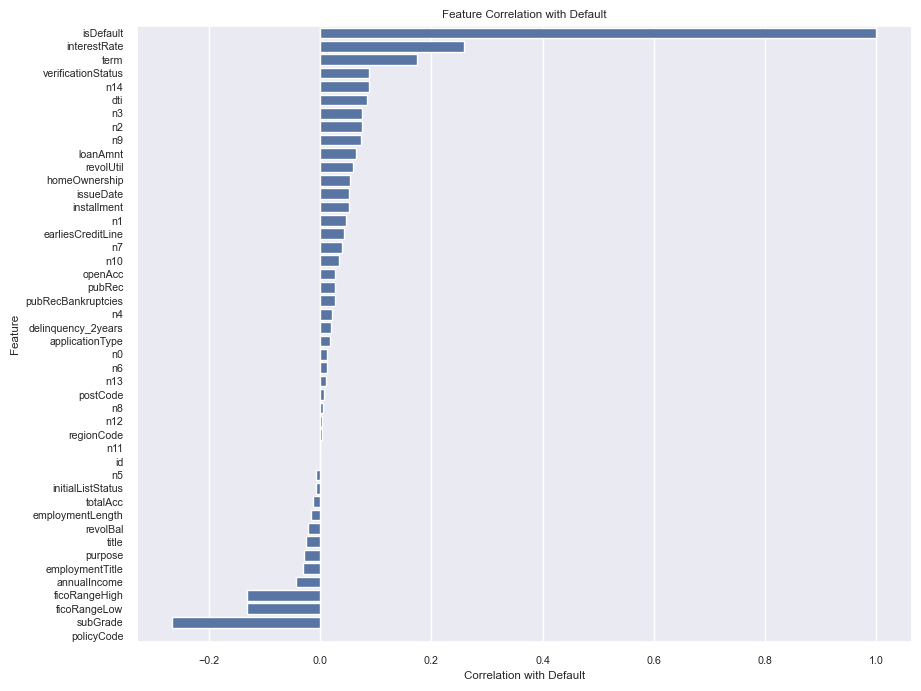

In [20]:
#Plot the graph
plt.figure(figsize=(10, 8))
sns.barplot(x='Correlation with Default', y='Feature', data=correlation_with_default_df)
plt.title('Feature Correlation with Default')
plt.show()